# Import Dependencies

In [1]:
!zip -r dataset.zip dataset

	zip warning: name not matched: dataset

zip error: Nothing to do! (try: zip -r dataset.zip . -i dataset)


In [ ]:
!pip install umap-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.insert(0,'/content/drive/Shareddrives/artworks-reconstruction')

Mounted at /content/drive


In [3]:
import os
import shutil
import json
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading
import concurrent.futures

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy import ndimage as ndi
from sklearn.metrics.pairwise import cosine_similarity
from skimage.feature import hog
from skimage.filters import gabor_kernel
from tqdm.notebook import tqdm

from preprocessing.image_conversion import resize_reference_image
from clustering import *

# Dataset Creation

In [ ]:
def read_fragments(fragments_dir: str, denoise: bool = True, max_dim: tuple[int, int] = (200, 200)) -> (np.array, dict):
    fragments = []
    fragments_reading_order = {}

    filenames = os.listdir(fragments_dir)
    for idx, filename in tqdm(enumerate(filenames), desc="Reading fragments", total=len(filenames)):
        fragments_reading_order[filename] = idx
        fragment = cv.imread(os.path.join(fragments_dir, filename), cv.IMREAD_UNCHANGED)
        fragment = cv.cvtColor(fragment, cv.COLOR_BGR2HSV)
        fragment = cv.resize(fragment, max_dim[::-1]) # invert from (w, h) to (h, w) to match numpy's standard

        if denoise:
            fragment = cv.fastNlMeansDenoisingColored(fragment)

        fragments.append(fragment)

    return np.array(fragments), fragments_reading_order

def read_references(references_dir: str, denoise: bool = True, max_dim: tuple[int, int] = (1000, 1000)) -> (list[np.array], list[int]):
    references = []
    references_ids = []

    filenames = os.listdir(references_dir)
    for filename in tqdm(filenames, desc="Reading references", total=len(filenames)):
        reference = cv.imread(os.path.join(references_dir, filename), cv.IMREAD_UNCHANGED)
        reference = cv.cvtColor(reference, cv.COLOR_BGR2HSV)
        reference = resize_reference_image(reference, max_dim[0])

        if denoise:
            reference = cv.fastNlMeansDenoisingColored(reference)

        references.append(reference)
        references_ids.append(int(filename.split(".")[1]))

    return references, references_ids

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

def compute_similarity_matrix(feats):
    n_images = len(feats)
    similarity_matrix = np.zeros((n_images, n_images))
    for i in range(n_images):
        for j in range(n_images):
            similarity_matrix[i, j] = np.linalg.norm(feats[i] - feats[j])
    return similarity_matrix

# Prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4.0 * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

# Barbara

In [ ]:
def minmax_norm(values: np.array) -> np.array:
    min_val = np.min(values)
    max_val = np.max(values)

    if max_val - min_val == 0:
        return 0
    return (values - min_val) / (max_val - min_val)


def create_composite_image(fragments: np.array, image_size: tuple[int, int, int]) -> np.array:
    width, height, channels = image_size
    # create a blank canvas for the composite image
    composite_image = np.zeros(image_size, dtype=np.uint8)
    composite_area = width * height
    n_fragments = len(fragments)
    fragment_size = int(np.sqrt(composite_area / n_fragments))

    x = 0
    y = 0
    for i in range(n_fragments):
        x_offset = x * fragment_size
        y_offset = y * fragment_size
        size = (fragment_size, fragment_size)

        x += 1

        area_to_cover = composite_image[x_offset:x_offset + fragment_size, y_offset:y_offset + fragment_size].shape[:2]
        # resize the fragment if it goes over outbounds the width or the height
        if area_to_cover[0] < fragment_size:
            # increment row and reset col where to insert the fragment
            x = 0
            y += 1
            if area_to_cover[0] == 0:
                x_offset = x * fragment_size
                y_offset = y * fragment_size
            else:
                size = (area_to_cover[0], fragment_size)
        elif area_to_cover[1] < fragment_size:
            size = (fragment_size, area_to_cover[1])

        # resize the fragment it it goes over outbounds the width or the height

        res_fragment = cv.resize(fragments[i], size[::-1])
        composite_image[x_offset:x_offset + fragment_size, y_offset:y_offset + fragment_size] = res_fragment

    # Handle remaining area if the fragments do not perfectly fill the image
    # Find the bounding box around non-black pixels
    non_black_pixels = np.argwhere(composite_image.sum(axis=2) > 0)
    min_y, min_x = np.min(non_black_pixels, axis=0)
    max_y, max_x = np.max(non_black_pixels, axis=0)

    # Crop the composite image to the bounding box
    cropped_composite_image = composite_image[min_y:max_y+1, min_x:max_x+1]
    # Resize the cropped composite image to the original width and height
    return cv.resize(cropped_composite_image, (width, height))


def compute_SIFT_matches(reference_image: np.array, composite_image: np.array) -> tuple[float, int]:
    sift = cv.SIFT_create()
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck = False)

    composite_image = cv.resize(composite_image, reference_image.shape[:2][::-1])

    plt.subplot(1, 2, 1)
    plt.title("Reference Image")
    plt.imshow(reference_image)
    plt.subplot(1, 2, 2)
    plt.title("Composite Image")
    plt.imshow(composite_image)
    plt.show()

    composite_image_keypoints, composite_image_descriptor = sift.detectAndCompute(composite_image, None)
    reference_keypoints, reference_descriptor = sift.detectAndCompute(reference_image, None)

    # Perform the matching between the SIFT descriptors of the fragment image and the reference image
    matches = bf.match(composite_image_descriptor, reference_descriptor)
    distances = [match.distance for match in matches]
    n_distances = len(distances)

    if n_distances:
        matches_median = np.median(distances)
        if not np.isnan(matches_median):
            return matches_median, n_distances
    return np.nan, n_distances


def choose_IN_cluster(reference_image: np.array, reference_id: int, root_dir: str, fragments: np.array, fragments_reading_order: dict,
                      image_size: tuple[int, int, int], color_weights: list[int], choice_weights: list[int]) -> (str, str, float, float):

    reference_color_histogram = cv.calcHist([reference_image], [0, 1, 2], None, (8, 8, 8), [0, 256, 0, 256, 0, 256])
    cv.normalize(reference_color_histogram, reference_color_histogram, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    candidate_clusters = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    scores = []
    recalls = []
    distances = []
    matches = []
    histograms = []
    n_fragments = []
    total_fragments = len(fragments)

    for candidate_cluster in candidate_clusters:
        # filter out only the fragments contained in this specific cluster directory
        cluster_indexes = [fragments_reading_order[filename] for filename in os.listdir(os.path.join(root_dir, candidate_cluster))]
        cluster_fragments = fragments[cluster_indexes]

        composite_image = create_composite_image(cluster_fragments, image_size)

        composite_color_histogram = cv.calcHist([composite_image], [0, 1, 2], None, (8, 8, 8), [0, 256, 0, 256, 0, 256])
        cv.normalize(composite_color_histogram, composite_color_histogram, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
        median_distance, n_matches = compute_SIFT_matches(reference_image, composite_image)

        distances.append(median_distance)
        matches.append(n_matches)
        histograms.append(composite_color_histogram)
        n_fragments.append(len(cluster_fragments))

    max_distance = max(distances)
    max_matches = max(matches)

    print(f"Max distance: {max_distance} - Max N. Matches: {max_matches}")

    for i in range(len(candidate_clusters)):
        color_correlation = cv.compareHist(reference_color_histogram, histograms[i], cv.HISTCMP_CORREL)
        color_intersection = cv.compareHist(reference_color_histogram, histograms[i], cv.HISTCMP_INTERSECT) / np.sum(histograms[i])

        color_similarity = (1 - (color_weights[0] * color_correlation + color_weights[1] * color_intersection))

        norm_distance = distances[i] / max_distance
        norm_matches = matches[i] / max_matches
        norm_n_fragments = n_fragments[i] / total_fragments

        score = choice_weights[0] * (norm_matches - norm_distance) + choice_weights[1] * color_similarity + choice_weights[2] * norm_n_fragments
        recall = recall_in_out_clusters(reference_id, root_dir, [candidate_clusters[i]])
        recalls.append(recall)
        scores.append(score)

        print(f"Cluster: {candidate_clusters[i]} - Color Similarity: {color_similarity:.2f} - Distance: {distances[i]} - N. Matches: {matches[i]} - Score: {score:.2f} - Recall: {recall:.2f}")

    # Return the cluster directory with the highest score
    max_score_idx = np.argmax(scores)
    max_recall_idx = np.argmax(recalls)

    return candidate_clusters[max_score_idx], candidate_clusters[max_recall_idx], recalls[max_score_idx], recalls[max_recall_idx]


def find_elbow_point(values, show_plot = False):
  norm_values = (values - values.min()) / (values.max() - values.min())

  # Calculate distances to the line formed by the first and last points
  n_points = len(norm_values)
  all_coords = np.vstack((range(n_points), norm_values)).T
  line_vec = all_coords[-1] - all_coords[0]
  line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
  vec_from_first = all_coords - all_coords[0]
  scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
  vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
  vec_to_line = vec_from_first - vec_from_first_parallel
  distances = np.sqrt(np.sum(vec_to_line**2, axis=1))

  # Find the elbow point
  elbow_idx = np.argmax(distances)
  elbow_value = values[elbow_idx]

  if show_plot:
      plt.figure()
      plt.plot(range(n_points), norm_values, 'b-', marker='o')
      plt.plot([0, n_points - 1], [norm_values[0], norm_values[-1]], 'r--')
      plt.plot(elbow_idx, norm_values[elbow_idx], 'ro')
      plt.title('Elbow Point Detection')
      plt.xlabel('Index')
      plt.ylabel('Values')
      plt.show()

      print(f"Elbow idx: {elbow_idx} - Elbow value: {elbow_value}")

  return elbow_idx, elbow_value


def recall_in_cluster(reference_image_id: int, reference_cluster_dir: str, data_dir: str) -> float:
    """
    Calculate the recall of the reference image within the reference cluster directory.

    Recall measures the proportion of relevant items that are retrieved.

    Args:
        reference_image_id (int): The ID of the reference image.
        reference_cluster_dir (str): The directory containing the reference cluster images.
        data_dir (str): The directory containing the dataset images.

    Returns:
        float: The recall value.
    """
    tp = 0
    tp_filenames = set()

    # Count true positives in the reference cluster directory
    for filename in os.listdir(reference_cluster_dir):
        if filename.split(".")[1] == str(reference_image_id):
            tp += 1
            tp_filenames.add(filename)

    # Count false negatives in the data directory
    fn = sum(1 for filename in os.listdir(data_dir) if filename.split(".")[1] == str(reference_image_id) and filename not in tp_filenames)

    total = tp + fn

    return tp / total if total else 0.0

def remove_empty_bins(histograms):
  max_shape = 0
  for i in range(len(histograms)):
    histograms[i] = histograms[i][np.where(histograms[i] != 0)] # remove empty bins
    max_shape = max(max_shape, histograms[i].shape[0])

  # Reshape each histogram to have the maximum shape
  for i in range(len(histograms)):
      current_shape = histograms[i].shape[0]
      if current_shape < max_shape:
          # Pad with zeros to match the maximum shape
          histograms[i] = np.pad(histograms[i], (0, max_shape - current_shape), mode='constant')

  return histograms

# Clustering

# CREA I DATASET

In [ ]:
# Define the path to the CSV file
quesito_dir = '/content/drive/Shareddrives/artworks-reconstruction/Dataset/Quesito_2_Dataset/'
top_middle_bottom = ['Top', 'Middle', 'Bottom']
left_center_right = ['Sinistra', 'Destra', 'Centrale']

quesito_splits = [split_dir for split_dir in os.listdir(quesito_dir) if os.path.isdir(quesito_dir)]
quesito_splits.remove('split50_orizzontale')
quesito_splits.remove('split50_verticale')
print(quesito_splits)

for quesito_split in quesito_splits:
     quesito_split_dir = os.path.join(quesito_dir, quesito_split)

     # Define the output directory for the fragments

     for csv_file in os.listdir(quesito_split_dir):
         if not csv_file.endswith(".csv") or "referenza" not in csv_file:
             continue

         df = pd.read_csv(os.path.join(quesito_split_dir, csv_file))

         csv_filebasename = csv_file.split(".")[0]

         positions = top_middle_bottom if (quesito_split == 'split33_orizzontale') else left_center_right

         for pos in positions:
             references_dir = f"dataset/{quesito_split}/{csv_filebasename}/{pos}/references"
             fragments_dir = f"dataset/{quesito_split}/{csv_filebasename}/{pos}/data"

             os.makedirs(references_dir, exist_ok=True)
             os.makedirs(fragments_dir, exist_ok=True)

             row_idx = 0

             # Process each row in the CSV file
             for index, row in tqdm(df.iterrows(), desc=f"Creating {pos} reference dataset", total=30):
                 reference_image_path = row['Reference Image']

                 if row_idx == 30:
                     break

                 if reference_image_path.split(os.path.sep)[-2] != pos:
                     continue

                 row_idx += 1

                 reference_image_path = reference_image_path.replace(f"MyDrive{os.path.sep}Dataset_Artworks",
                                                                     f"Shareddrives{os.path.sep}artworks-reconstruction{os.path.sep}")
                 reference_new_image_path = os.path.join(references_dir, reference_image_path.split(os.path.sep)[-1])

                 !cp {reference_image_path} {reference_new_image_path}

                 for i in range(1, len(df.columns)):
                     fragment_path = row[f'Associated Fragment Path {i}']

                     if isinstance(fragment_path, float) and pd.isna(fragment_path):
                         break

                     # replace with actual path
                     fragment_path = fragment_path.replace(f"MyDrive{os.path.sep}Dataset_Artworks",
                                                           f"Shareddrives{os.path.sep}artworks-reconstruction{os.path.sep}")
                     fragment_path_split = fragment_path.split(os.path.sep)
                     fragment_new_name = fragment_path_split[-2] + "_" + fragment_path_split[-1]
                     fragment_new_path = os.path.join(fragments_dir, fragment_new_name)

                     !cp {fragment_path} {fragment_new_path}

['split33_verticale', 'split33_orizzontale']


Creating Sinistra reference dataset: 78it [31:20, 24.10s/it]                        
Creating Destra reference dataset: 78it [17:20, 13.34s/it]
Creating Centrale reference dataset: 78it [04:05,  3.14s/it]
Creating Sinistra reference dataset: 78it [23:33, 18.13s/it]                        
Creating Destra reference dataset: 78it [13:13, 10.17s/it]
Creating Centrale reference dataset:  97%|█████████▋| 29/30 [00:23<00:01,  1.15s/it]

# FAI CLUSTERING

In [ ]:
fragments_dir = "data"
references_dir = "references"
max_fragments_dims = (100, 100)
max_references_dims = (1000, 1000)
references_working_region_threshold = 20

output_dir = "clusters"
in_clusters_dir = "in_clusters"
image_size = (1000, 1000, 3)
seed = 42
weak_pixel_threshold = 50
strong_pixel_threshold = 150
k = 2

choice_weights = [0.5, 0.5, 0.3]
color_weights = [0.5, 0.5]

patch_similarity_threshold = 0.5

max_workers = os.cpu_count()
lock = threading.Lock()

In [ ]:
def process_patch(args):
    IN_cluster_fragment, IN_fragments_filename, IN_color_histogram, IN_cluster_edge, IN_cluster_texture, i, j, max_fragments_dims, reference_image, kernels = args

    patch = reference_image[i:i + max_fragments_dims[0], j:j + max_fragments_dims[1]]
    if patch.shape != IN_cluster_fragment.shape:
        patch = cv.resize(patch, max_fragments_dims[::-1])

    patch_rgb = cv.cvtColor(patch, cv.COLOR_HSV2RGB)
    patch_gray = cv.cvtColor(patch_rgb, cv.COLOR_RGB2GRAY)
    patch_texture_features = compute_feats(patch_gray, kernels)
    patch_texture_features = minmax_norm(patch_texture_features)

    patch_color_histogram = cv.calcHist([patch], [0, 1, 2], None, (8, 8, 8), [0, 256, 0, 256, 0, 256])
    cv.normalize(patch_color_histogram, patch_color_histogram, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    patch_color_histogram = patch_color_histogram.flatten()

    fragment_color_histogram = IN_color_histogram.flatten()

    fragment_patch_color_distance = cv.compareHist(
        patch_color_histogram, fragment_color_histogram, cv.HISTCMP_INTERSECT
    ) / np.minimum(np.sum(fragment_color_histogram), np.sum(patch_color_histogram))

    # Extract edges
    patch_edges = cv.Canny(patch_gray, weak_pixel_threshold, strong_pixel_threshold) / 255
    edge_sim = cosine_similarity(patch_edges, IN_cluster_edge)[0][0]
    texture_sim = cosine_similarity(patch_texture_features, IN_cluster_texture)[0][0]

    sim_score = (edge_sim + texture_sim + fragment_patch_color_distance) / 3

    if sim_score >= patch_similarity_threshold:
        with lock:
            refined_IN_fragments.append(IN_cluster_fragment)
            refined_filenames.append(IN_fragments_filename)
        return True  # Signal to skip the fragment
    return False

Reading fragments:   0%|          | 0/2087 [00:00<?, ?it/s]

Reading references:   0%|          | 0/26 [00:00<?, ?it/s]

Computing color histograms:   0%|          | 0/2087 [00:00<?, ?it/s]

Extracting texture and HOG features:   0%|          | 0/2087 [00:00<?, ?it/s]

Iteration 1 out of 26 - Reference ID 25
---------------------------------------------


Creating dataset for Reference 25:   0%|          | 0/2087 [00:00<?, ?it/s]

Creating cluster dirs:   0%|          | 0/2087 [00:00<?, ?it/s]

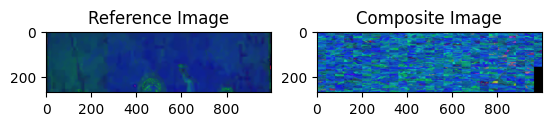

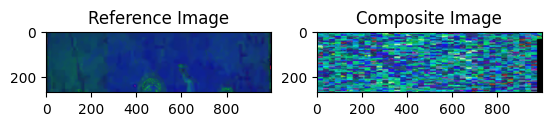

Max distance: 3555.0 - Max N. Matches: 3004
Cluster: cluster_1 - Color Similarity: 1.01 - Distance: 3490.0 - N. Matches: 1943 - Score: 0.43 - Recall: 0.36
Cluster: cluster_0 - Color Similarity: 1.01 - Distance: 3555.0 - N. Matches: 3004 - Score: 0.71 - Recall: 0.64
Recall: 0.64


Extracting patches from Reference ID 25:   0%|          | 0/1448 [00:00<?, ?it/s]

In [ ]:
split_dirs = [split_dir for split_dir in os.listdir("dataset") if os.path.isdir(os.path.join("dataset", split_dir))]

for split_dir in split_dirs:
    split_dir_path = os.path.join("dataset", split_dir)
    csv_dirs = [csv_dir for csv_dir in os.listdir(split_dir_path) if os.path.isdir(os.path.join(split_dir_path, csv_dir))]
    for csv_dir in csv_dirs:
        csv_dir_path = os.path.join(split_dir_path, csv_dir)
        pos_dirs = [pos_dir for pos_dir in os.listdir(csv_dir_path) if os.path.isdir(os.path.join(csv_dir_path, pos_dir))]
        for pos_dir in pos_dirs:
            post_dir_path = os.path.join(csv_dir_path, pos_dir)
            references_dir = os.path.join(post_dir_path, "references")
            fragments_dir = os.path.join(post_dir_path, "data")

            fragments, fragments_reading_order = read_fragments(fragments_dir, max_dim=max_fragments_dims)
            references, references_ids = read_references(references_dir, max_dim=max_references_dims)
            fragments_paths = [os.path.join(fragments_dir, filename) for filename in fragments_reading_order.keys()]

            color_histograms = np.array(compute_color_histograms(fragments, flatten=False))
            n_fragments = len(fragments)
            texture_features = []
            hog_features = []
            fragment_edges = []

            for i in tqdm(range(n_fragments), desc="Extracting texture and HOG features",
                          total=n_fragments):
                fragment = fragments[i]
                fragment = cv.cvtColor(fragment, cv.COLOR_HSV2RGB)
                fragment = cv.cvtColor(fragment, cv.COLOR_RGB2GRAY)
                fragment_edge = edges = cv.Canny(fragment, weak_pixel_threshold, strong_pixel_threshold)
                features, hog_image = hog(fragment_edge, pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2), visualize=True)

                fragment_edges.append(fragment_edge)
                hog_features.append(features)
                texture_features.append(compute_feats(fragment, kernels))

            # normalize texture features
            texture_features = np.array(texture_features)
            normalized_texture_features = minmax_norm(texture_features)

            hog_features = np.array(hog_features)
            normalized_hog_features = minmax_norm(hog_features)
            normalized_hog_features = np.nan_to_num(normalized_hog_features, nan=0.0)

            fragment_edges = np.array(fragment_edges)
            normalized_fragment_edges = fragment_edges / 255

            n_references = len(references_ids)
            correct_IN_clusters = 0

            metrics_filename = f"{split_dir}_{csv_dir}_{pos_dir}.json"
            metrics = {}

            for i in range(n_references):
                reference_id = references_ids[i]
                reference_image = references[i]

                print(f"Iteration {i + 1} out of {n_references} - Reference ID {reference_id}")
                print("---------------------------------------------")

                reference_color_histogram = cv.calcHist([reference_image], [0, 1, 2], None, (8, 8, 8),
                                                        [0, 256, 0, 256, 0, 256])
                cv.normalize(reference_color_histogram, reference_color_histogram, alpha=0, beta=1,
                             norm_type=cv.NORM_MINMAX)

                # extract region working region and convert to grayscale
                reference_image_rgb = cv.cvtColor(reference_image, cv.COLOR_HSV2RGB)
                reference_image_gray = cv.cvtColor(reference_image_rgb, cv.COLOR_BGR2GRAY)
                # extract reference texture features starting from the borders and normalize them
                reference_texture_features = compute_feats(reference_image_gray, kernels)
                normalized_reference_texture_features = minmax_norm(reference_texture_features)

                X = []
                for _ in tqdm(range(n_fragments), desc=f"Creating dataset for Reference {reference_id}",
                              total=n_fragments):
                    fragment_reference_color_intersection = cv.compareHist(reference_color_histogram,
                                                                           color_histograms[_],
                                                                           cv.HISTCMP_INTERSECT) / np.minimum(
                        np.sum(color_histograms[_]), np.sum(reference_color_histogram))
                    X.append(np.hstack((color_histograms[_].reshape(-1), fragment_reference_color_intersection,
                                        np.multiply(normalized_texture_features[_],
                                                    normalized_reference_texture_features).reshape(
                                            -1))))  # texture intersection between reference image and fragment
                X = np.array(X)

                # Use Hierarchical Clustering to find better centroids for K-means init
                agg_clust = AgglomerativeClustering(n_clusters=k)
                fit_agg_clust = agg_clust.fit(X)
                labels = agg_clust.labels_
                # Approximate the centroids
                centroids = np.array([X[labels == i].mean(axis=0) for i in range(max(labels) + 1)])

                kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto", init=centroids)
                fit_kmeans = kmeans.fit(X)

                create_cluster_dirs(fragments_paths, output_dir=output_dir, labels=fit_kmeans.labels_)
                IN_cluster, correct_IN_cluster, IN_cluster_recall, correct_IN_cluster_recall = choose_IN_cluster(
                    reference_image,
                    reference_id,
                    output_dir,
                    fragments,
                    fragments_reading_order,
                    image_size,
                    color_weights,
                    choice_weights)
                if IN_cluster == correct_IN_cluster:
                    correct_IN_clusters += 1

                IN_cluster_path = os.path.join(output_dir, IN_cluster)

                IN_cluster_fragments_names = [filename for filename in os.listdir(IN_cluster_path)]
                IN_cluster_indexes = [fragments_reading_order[filename] for filename in IN_cluster_fragments_names]
                IN_cluster_fragments = fragments[IN_cluster_indexes]
                IN_color_histograms = color_histograms[IN_cluster_indexes]

                print(f"Recall: {recall_in_out_clusters(reference_id, output_dir, [IN_cluster]):.2f}")

                IN_cluster_fragments_flatten = IN_cluster_fragments.reshape(IN_cluster_fragments.shape[0], -1)

                # refine IN Cluster
                n_IN_fragments = len(IN_cluster_fragments)
                IN_cluster_edges = normalized_fragment_edges[IN_cluster_indexes]
                IN_cluster_textures = normalized_texture_features[IN_cluster_indexes]
                IN_color_histograms = color_histograms[IN_cluster_indexes]
                IN_fragments_filenames = [filename for filename, idx in fragments_reading_order.items() if
                                          idx in IN_cluster_indexes]

                refined_IN_fragments = []
                refined_filenames = []
                skip_fragment = False

                for _ in tqdm(range(n_IN_fragments), desc=f"Extracting patches from Reference ID {reference_id}"):
                    tasks = []
                    for i in range(0, reference_image.shape[0], max_fragments_dims[0]):
                        for j in range(0, reference_image.shape[1], max_fragments_dims[1]):
                            tasks.append((IN_cluster_fragments[_], IN_fragments_filenames[_], IN_color_histograms[_], IN_cluster_edges[_], IN_cluster_textures[_], i, j, max_fragments_dims, reference_image, kernels))

                    # Using ThreadPoolExecutor to process patches in parallel
                    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                        results = list(executor.map(process_patch, tasks))

                        # Wait for all threads to finish
                        executor.shutdown(wait=True)

                refined_IN_fragments_flatten = np.array(refined_IN_fragments)
                refined_IN_fragments_flatten = refined_IN_fragments_flatten.reshape(
                    refined_IN_fragments_flatten.shape[0], -1)

                # copy fragments and create refined IN-cluster dir
                refined_IN_cluster_path = os.path.join(in_clusters_dir, str(reference_id))

                if os.path.exists(refined_IN_cluster_path):
                    shutil.rmtree(refined_IN_cluster_path)
                os.makedirs(refined_IN_cluster_path, exist_ok=True)

                for filename in tqdm(refined_filenames,
                                     desc=f"Copying fragments to refined IN-Cluster dir for Reference ID {reference_id}",
                                     total=len(refined_filenames)):
                    shutil.copy(os.path.join(IN_cluster_path, filename),
                                os.path.join(refined_IN_cluster_path, filename))

                # compute pre-refining metrics
                metrics[reference_id] = {
                    "pre_refinement_precision": precision(reference_id, IN_cluster_path),
                    "pre_refinement_recall": recall_in_out_clusters(reference_id, output_dir, [IN_cluster]),
                    "pre_refinement_number_of_fragments": len(IN_cluster_fragments),
                    "post_refinement_precision": precision(reference_id, refined_IN_cluster_path),
                    "post_refinement_recall": recall_in_cluster(reference_id, refined_IN_cluster_path, fragments_dir),
                    "post_refinement_number_of_fragments": len(refined_filenames),
                    "reduction": 1 - (len(refined_filenames) / len(IN_cluster_fragments))
                }

            correct_guesses = correct_IN_clusters / n_references

            print("\n\nTerminated!\n\n")
            print(
                f"Correct IN cluster selected: {correct_IN_clusters}/{n_references} --- {(correct_guesses) * 100:.2f}%")

            metrics["barbara"] = {
                "correct_choices": f"{correct_IN_clusters}/{n_references}",
                "correct_choices_perc": f"{(correct_guesses) * 100:.2f}"
            }

            with open(metrics_filename, "w") as f:
                json.dump(metrics, f)

In [ ]:
for umap_images in umap_images_list_pre_refined:
    plt.scatter(umap_images[:, 0], umap_images[:, 1])
    plt.title("UMAP delle Immagini RGB")
    plt.xlabel("UMAP Dimensione 1")
    plt.ylabel("UMAP Dimensione 2")
    plt.show()

for umap_images in umap_images_list_post_refined:
    plt.scatter(umap_images[:, 0], umap_images[:, 1])
    plt.title("UMAP delle Immagini RGB")
    plt.xlabel("UMAP Dimensione 1")
    plt.ylabel("UMAP Dimensione 2")
    plt.show()